# Donor Analysis Using RFM Segmentation
> <i>This project explores donor behavior and giving patterns for Tokyo Student Mobilization, a non-profit organization focused on student outreach in Japan. The recency, frequency, and monetary (RFM) scoring method is used for donor segmentation, leading to a more robust categorization of donors according to their giving patterns. The goal is to uncover actionable insights that can support donor engagement, retention efforts and fundraising campaigns. </i>
>
> **Key Questions**
>- Do most donors have fairly symmetric giving patterns (little to no extreme outliers in their donation amounts)?
>- How is the donor base distributed across different states?
>- How many donors are recurring? 
>- Who are the most consistent and generous donors?
>- Are there donors who are at risk of lapsing and require re-engagement?

In [1]:
# Import relevant python packages
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline

## Data Sources & Context
> This project uses a subset of anonymized donor data provided by <b>Student Mobilization, Inc.</b> The dataset includes key features such as <b>transaction amounts</b>, <b>payment methods</b>, and <b>donor contact information</b>. Due to the sensitive nature of donor information, the raw CSV files <b>are not publicly shared</b> or uploaded to this notebook. All analyses, visualizations, and summaries are based on internal datasets and are presented sequentially throughout the project to protect individual privacy.
>
>  <i> <b>Note</b>: In the following sections, we refer to multiple donors throughout the data cleaning process. These are not the actual names of any of our donors; they are aliases used in place of real names to protect donor privacy.   </i>

## Data Loading & Initial Exploration
> The <b>donor</b> and <b>transaction</b> data are loaded from CSV files into <b>pandas DataFrames</b>. We begin by inspecting the structure of each dataset and reviewing descriptive statistics to understand key features, data types, and overall data quality. This step provides the foundation for all subsequent analysis.

In [2]:
# Maximize the display in the terminal 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

# Load the data from CSV files directly to pandas
donors_df = pd.read_csv('donors1.csv', header = 0)
transactions_df = pd.read_csv('transactions1.csv', header = 0)

In [ ]:
# Display a concise summary of the DataFrame, including column names, non-null counts, and data types
donors_df.info()

In [ ]:
transactions_df.info()

In [ ]:
# Get descriptive statistics for all DataFrame columns, including categorical and numeric data
donors_df.describe(include = 'all')

In [ ]:
transactions_df.describe(include = 'all')

## Data Cleaning & Preprocessing 
>- Negative donation amounts (e.g., refunds or entry errors) are removed from the `transactions_df`.  
>- We also rename the `Family Name` column in `donors_df` to `Donor Name` to match the transaction records and enable accurate merging later on.
>- Duplicated rows are dropped from `donors_df`.
>- Rows containing duplicate values in `Donor Name`, `Email`, and `Address Line 1` are inspected for ambiguous donor records.

In [ ]:
# Drop rows in transactions_df with negative amounts (e.g., -100.0) -- likely due to entry errors or refunds 
transactions_df = transactions_df[transactions_df['Amount'] > 0]

In [12]:
# Rename the Family Name column in donors_df to match the corresponding column in transactions_df 
donors_df.rename(columns={'Family Name': 'Donor Name'}, inplace = True)

In [13]:
# Drop duplicate rows in donors_df
donors_df.drop_duplicates(inplace = True)

In [ ]:
# Define masks for filtering through donors_df 
email_mask = donors_df['Email'].duplicated(keep = False) & donors_df['Email'].notnull()
address_mask = donors_df['Address Line 1'].duplicated(keep = False) & donors_df['Address Line 1'].notnull()
name_mask = donors_df['Donor Name'].duplicated(keep = False) & donors_df['Donor Name'].notnull()

# Locate rows that contain duplicates in the Donor Name, Email, and Address Line 1 columns
donors_df[name_mask | email_mask | address_mask]

### Disambiguating Duplicate Donor Names

In [ ]:
# Investigate the duplication of name 'Quinn Maddox' 
transactions_df.loc[transactions_df['Donor Name'] == 'Quinn Maddox']

> During exploration, we discovered multiple entries for the donor name **"Quinn Maddox"**, which appear to correspond to different individuals based on their email addresses and payment methods. 
> 
> To ensure accurate analysis and merging, we disambiguate these records by:
> - Identifying distinct email patterns (`quinn_cat` and `abquinn`)
> - Matching them to corresponding payment types (`Credit Card` and `ACH`)
> - Renaming both donor and transaction records with unique identifiers
> 
> This step helps to prevent attributing transactions to the wrong individual when merging and aggregating data. 

In [ ]:
# Label ambiguous names in donors_df and transactions_df according to their unique email addresses
quinn_maddox = {
    'emails': ['quinn_cat', 'abquinn'],
    'payments': ['Credit Card', 'ACH']
}
for idx, addrs in enumerate(quinn_maddox['emails']):
    payment = quinn_maddox['payments'][idx]
    donors_df.loc[donors_df['Email'].notnull() & donors_df['Email'].str.contains(addrs), 'Donor Name'] = f'Quinn Maddox ({addrs})'
    
    pay_mask = transactions_df['Currency Type'] == payment # define a mask for filtering rows in transactions_df by transaction type
    transactions_df.loc[pay_mask, 'Donor Name'] = transactions_df.loc[pay_mask, 'Donor Name'].replace({'Quinn Maddox' : f'Quinn Maddox ({addrs})'})

### Normalizing Donor Names
> In this step, we normalize inconsistent donor names across the transaction dataset. Some donors appear under multiple name variants (e.g., misspellings, last name changes, spouse name included).
>
> To address this, we:
> - Define a mapping from partial or inconsistent name patterns (e.g., "Levesque")  
> - Replace them with a consistent, unified name for each donor in the `transactions_df`.
>
> This ensures that all contributions are properly attributed to the corresponding donors when merging and aggregating data.

In [ ]:
# Normalize inconsistent donor names by mapping from partial name patterns to a consistent, unified name for each donor   
name_mapping = {
    'locators': ['Jordan', 'Devon', 'Levesque', 'Ames', 'Parker'],
    'map_to': ['Jordan Reeves', 'Devon Cross', 'Tatum Levesque', 'Alex Ames', 'Dakota Parker']
}
for idx, loc in enumerate(name_mapping['locators']):
    transactions_df.loc[transactions_df['Donor Name'].str.contains(loc), 'Donor Name'] = name_mapping['map_to'][idx]

### Manual Location Input for Missing Donor Data
>Some donors were missing location information in the original dataset. We manually added `City`, `State`, and `Country` values for these donors based on external knowledge. These columns will be helpful in any location-based analyses or segmentation (e.g., state-by-state analysis of total donation amounts).
>
>- `Ellis` → Salt Lake City, UT, US  
>- `Monroe` → Austin, TX, US  
>- `Sinclair` → Denver, CO, US

In [ ]:
# Manually input missing locations for donors (City, State, Country) 
donors_df.loc[donors_df['Donor Name'].str.contains('Ellis'), ['City', 'State', 'Country']] = ['Salt Lake City', 'UT', 'US']
donors_df.loc[donors_df['Donor Name'].str.contains('Monroe'), ['City', 'State', 'Country']] = ['Austin', 'TX', 'US']
donors_df.loc[donors_df['Donor Name'].str.contains('Sinclair'), ['City', 'State', 'Country']] = ['Denver', 'CO', 'US']

### Null Value Inspection & Column Pruning
>Before continuing with analysis, we:
>- **Check for missing values** in both `donors_df` and `transactions_df`.
>- **Drop unnecessary columns** that are either irrelevant to our goals and analysis.
>
>- From `donors_df`: `Donor Type`, `Email`, `Address Line 1`, `Address Line 2`, `Postal Code`
>- From `transactions_df`: `Recurring`, `Description`

In [ ]:
# Inspect the DataFrames for null values
print(donors_df.isnull().sum())
print(transactions_df.isnull().sum())

In [ ]:
# Drop columns that will not be necessary for our analysis
donors_df.drop(columns = ['Donor Type', 'Email', 'Address Line 1', 'Address Line 2', 'Postal Code'], inplace = True)
transactions_df.drop(columns = ['Recurring', 'Description'], inplace = True)

## Feature Engineering: Donor-Level Metrics
>In this section, we engineer key features that summarize each donor's giving behavior based on the raw transactions dataset. For the most part, transactions are grouped by `Donor Name`, aggregated, and then merged into the `donors_df`. These features are critical for segmenting donors according to their giving behavior.

### Timestamp Conversion
> We start by ensuring all donation dates are in a consistent pandas datetime format (with timezones removed to simplify calculations).

In [ ]:
# Convert all timestamps to pandas datetime objects
transactions_df['Date'] = pd.to_datetime(transactions_df['Date']).dt.tz_localize(None) # removing the timezone localization reduces complications in pandas datetime functions

### Aggregating Donor-Level Features
>We define a function to help simplify aggregating feature metrics and merging into `donors_df`.

In [ ]:
# Compute and merge aggregated features per donor 
def add_agg_feature(donors_df, transactions_df, col, agg, new_feature):
    df_feature = transactions_df.groupby('Donor Name', as_index = False).agg({col : agg})
    df_feature.rename(columns = {col : new_feature}, inplace = True)
    return pd.merge(donors_df, df_feature[['Donor Name', new_feature]], how = 'inner', on = 'Donor Name')

>We then compute and merge the following features (per donor):
> - Frequency: total number of donations 
> - Monetary: total amount donated 
> - Donation Statistics: mean, median, maximum, and minimum donation amounts 
> - Donation Timeline: first and last donation dates 
> - Recency: number of days since last donation
> - Recurring Flag: 1 if donor gave more than once, 0 otherwise

In [ ]:
# Compute number of donations (frequency)
donation_counts_df = transactions_df['Donor Name'].value_counts().reset_index()
donation_counts_df.rename(columns = {'count' : 'frequency'}, inplace = True)
donors_df = pd.merge(donors_df, donation_counts_df[['Donor Name', 'frequency']], how = 'inner', on = 'Donor Name')

# Compute total amount donated (monetary)
donors_df = add_agg_feature(donors_df, transactions_df, 'Amount', 'sum', 'monetary') 

# Compute donation statistics
donors_df = add_agg_feature(donors_df, transactions_df, 'Amount', 'mean', 'mean_amount')
donors_df = add_agg_feature(donors_df, transactions_df, 'Amount', 'median', 'med_amount')
donors_df = add_agg_feature(donors_df, transactions_df, 'Amount', 'max', 'max_amount')
donors_df = add_agg_feature(donors_df, transactions_df, 'Amount', 'min', 'min_amount')

# Compute donation date features
donors_df = add_agg_feature(donors_df, transactions_df, 'Date', 'min', 'donation_start_date')
donors_df = add_agg_feature(donors_df, transactions_df, 'Date', 'max', 'last_donation_date')

# Compute days since last donation (recency)
donors_df['recency'] = (pd.to_datetime(datetime.now()) - donors_df['last_donation_date']).dt.days

# Label donors according to their giving patters (one-time vs. recurring donor)
donors_df['is_recurring'] = donors_df['frequency'].apply(lambda x : 1 if x > 1 else 0)

# View the resulting DataFrame
donors_df.head()

## Exploratory Data Analysis With Matplotlib/Seaborn

### Overview of Donation Amounts and Donor Types
>This section explores two key patterns in donor behavior:
>- The distribution of individual donation amounts.
>- The breakdown of one-time versus recurring donors.

In [ ]:
# Initialize figure with 2 subplots 
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

# Set figure style 
sns.set_style("whitegrid")

# Define a color palette to be used in the following plots 
palette = sns.color_palette("muted", 3)

# Log transform donation amounts to capture large value ranges
log_amounts_df = np.log10(transactions_df['Amount']).to_frame()

# Histogram for log-transformed donation amounts
sns.histplot(data = log_amounts_df, x = 'Amount', ax = ax[0], color = palette[0])
ax[0].set_ylabel('Frequency', fontsize = 16)
ax[0].set_xlabel('Log-Transformed Amount (USD)', fontsize = 16)
ax[0].set_title('Distribution of Donations', fontweight = 'bold', fontsize = 20)

# Compute the number of recurring vs one-time donors 
recurring_counts = donors_df['is_recurring'].value_counts().sort_index()
labels = ['One-Time', 'Recurring']

# Pie chart for recurring vs. one-time donors
explode = [0, 0.1]
ax[1].pie(recurring_counts, labels = labels, colors = palette[1:], explode = explode, autopct = '%.0f%%', textprops = {'fontsize': 16})
ax[1].set_title('Recurring vs One-Time Donors', fontsize = 20, fontweight = 'bold')
fig.tight_layout()
plt.savefig('donation_patterns.png')

>**Distribution of Donation Amounts**
>- The histogram displays the log-transformed distribution of all donation amounts to account for the skew caused by large gifts.
>- The distribution indicates that most donations fall between <b>50 and 100 dollars</b>.
>  
>**Recurring vs. One-Time Donors**
>- The pie chart shows that <b>77%</b> of donors have given <b>more than one time</b>.

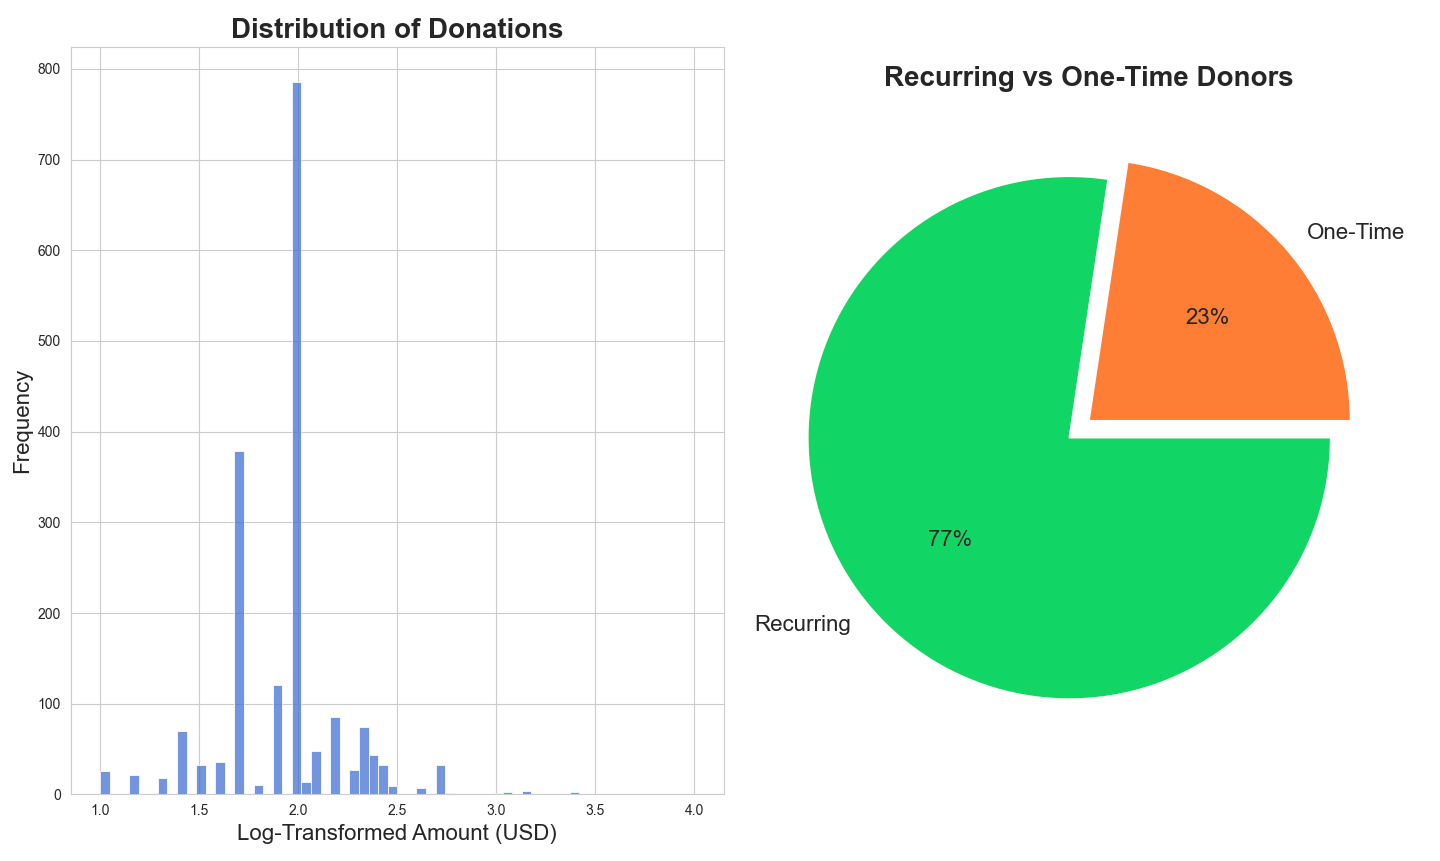

### Top One-Time Donors (By Total Giving)
>This table highlights the top 10 **one-time donors**, ranked by their total donation amount (monetary value).  
>
>To maintain donor privacy, real names have been replaced with anonymous labels (e.g., `Donor_0`, `Donor_1`, etc.).
>
>These donors contributed significantly despite not giving on a recurring basis which could suggest that they have a high capacity for giving in one-time events (e.g., end-of-the-year fundraising campaigns) and may be targeted for future engagement. 

In [5]:
# Show top 10 one-time donors (according to monetary value)
one_time_donors = donors_df.loc[donors_df['is_recurring'] == 0, ['Donor Name', 'monetary', 'recency']].sort_values(by = 'monetary', ascending = False).reset_index(drop = 'index').head(10)
one_time_donors.loc[:, 'Donor Name'] = [f'Donor_{idx}' for idx in range(10)] # assign aliases to donor names to protect privacy
one_time_donors

,Donor Name,monetary,recency
0,Donor_0,10000.0,298
1,Donor_1,7500.0,1057
2,Donor_2,2500.0,1020
3,Donor_3,1500.0,455
4,Donor_4,1200.0,397
5,Donor_5,1200.0,1047
6,Donor_6,1100.0,483
7,Donor_7,1000.0,18
8,Donor_8,750.0,456
9,Donor_9,600.0,399


### Distribution of Mean-Median Differences in Donor Giving
>This histogram shows the distribution of the absolute difference between the **mean** and **median** donation amounts per donor.
>
>The **mean–median difference** helps identify how consistent donors are in their giving behavior:
>
>- A small gap may suggest consistent giving patterns or, at least, the lack of extreme outliers. 
>- A large gap may indicate occasional large outlier donations or irregular giving patters.
>
> This insight can help flag donors who may require more personalized engagement strategies — for example, those who give irregularly might benefit more consistent giving opportunities through engagement.


In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Set figure style  
sns.set_style("whitegrid")

# Define a color to be used in the following histogram
color = sns.color_palette("muted", 4)[3] # choose third color in the "muted" palette

# Compute |mean_amount - med_amount| for each donor 
mean_med_diff = np.abs(donors_df['mean_amount'] - donors_df['med_amount'])

# Histogram of mean-median differences in donation amounts
sns.histplot(x = mean_med_diff, binwidth = 10, color = color)
plt.title('Distribution of Giving Gaps', fontsize = 20, fontweight = 'bold')
plt.xlabel('Mean–Median Difference in Donation Amounts (USD)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.savefig('mean_med_diff_hist.png')

>**Distribution of Giving Gaps**
>
>- The histogram suggests that most donors give fairly **consistently**, with donation amounts that do not vary dramatically over time.
>
> In other words, their giving patterns are relatively **symmetrical**, rather than **skewed** by occasional large or small donations (relative to their typical donation amounts).

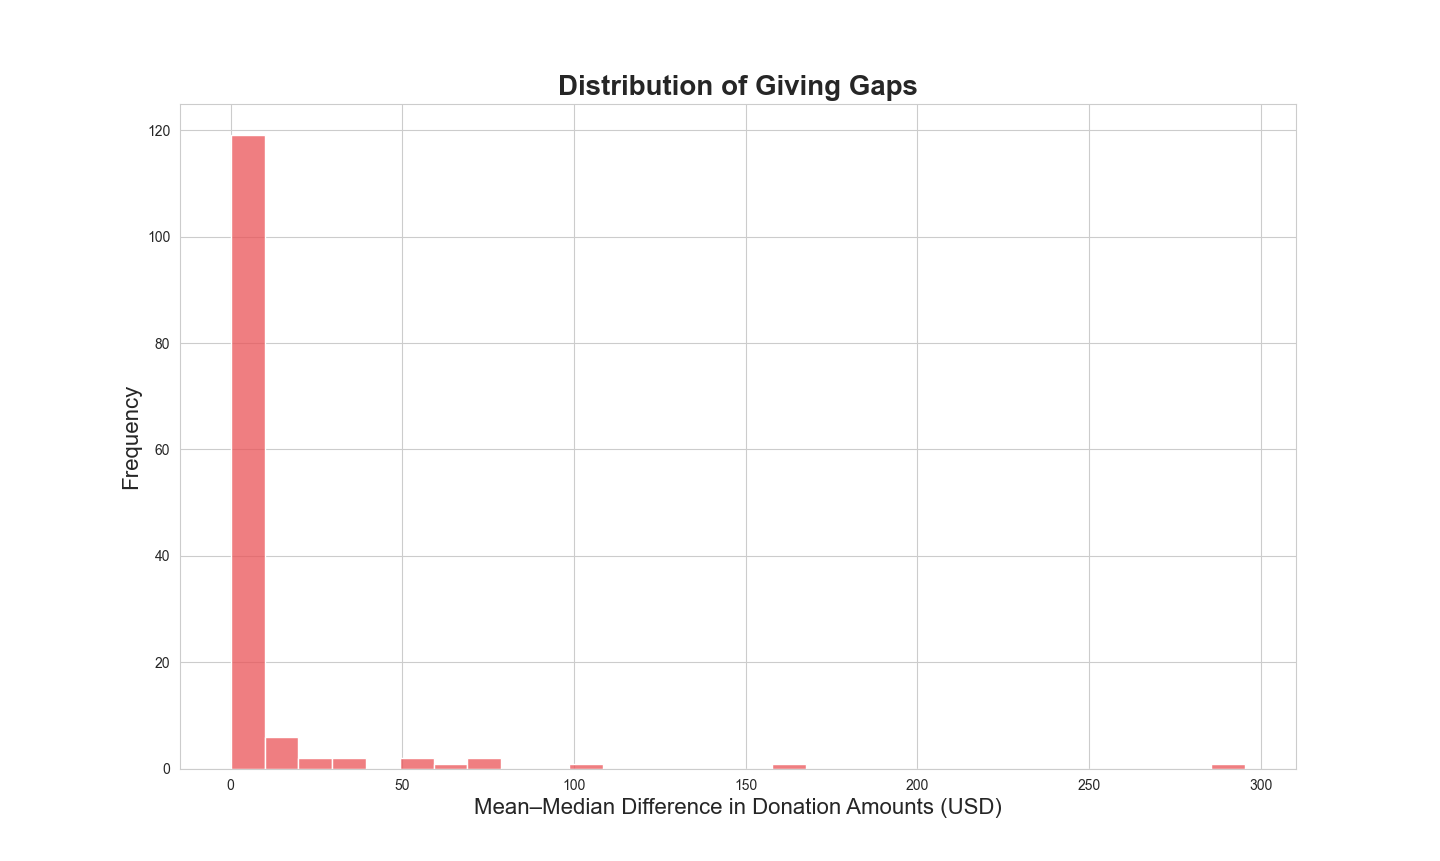

### Distribution of Recency, Frequency, and Monetary (RFM) Value
>In this section, we visualize the distribution of the three key RFM (Recency, Frequency, Monetary) features using box plots.
>
> This helps us:
>- Understand the range and central tendency of each feature.
>- Identify the presence of outliers.
>- Assess the skewness of each distribution. 

In [ ]:
# Define RFM features
rfm_features = ['recency', 'frequency', 'monetary']

# Define a color palette to be used in the following box plots -- unique colors for each feature 
palette = sns.color_palette("muted", 3)

# Initialize figure with 3 subplots 
fig, ax = plt.subplots(1, 3, figsize = (15, 8))

# Set the figure style 
sns.set_style("whitegrid")

# Box plots for RFM features
fig.suptitle('Distribution of RFM Value', fontsize = 20, fontweight = 'bold')
for i, feat in enumerate(features):
	sns.boxplot(y = donors_df[feat], showfliers = True, ax = ax[i], saturation = 0.5, width = 0.7, color = palette[i], flierprops = {'mfc' : palette[i], 'mec' : 'black'})
	ax[i].set_ylabel(feat, fontsize = 16)
fig.tight_layout()
plt.savefig('rfm_features_box.png')

>**RFM Distributions**
>
>- All three features are right-skewed, with varying degrees of severity.
>- **Recency**: The median, lower quartile, and minimum are all very close together despite a wide, overall range. This suggests that most donors have given recently while few donors have not given in a long time.
>- **Frequency**: The right-skewed distribution indicates that a small number of donors contribute very frequently, while most give less often.
>- **Monetary**: The presence of extreme outliers highlights a few exceptionally generous donors.

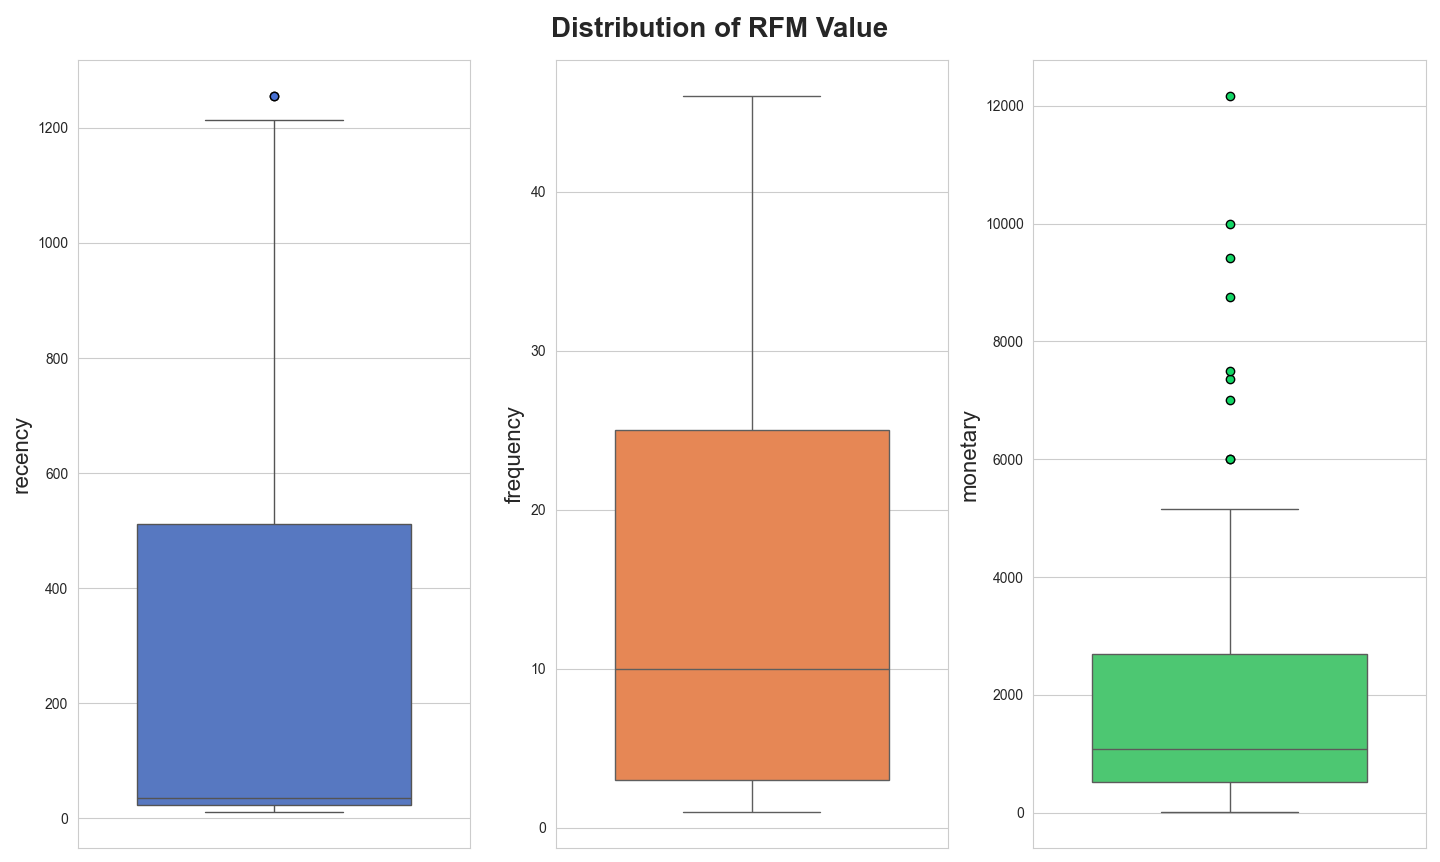

### State-by-State Analysis of Donation Totals and Donor Numbers
>To understand the geographic distribution of giving behavior, we conducted a state-level analysis of donor contributions which shows:
>- The total donation amount contributed by donors in each state.
>- The number of individual donors per state, offering insight into regional donor concentration. 
>
> These findings are especially useful for strategic planning. Since we travel to the U.S. once a year for in-person donor engagement and fundraising, this data helps us prioritize which states or regions to focus our efforts on, maximizing relational and fundraising impact.


In [ ]:
# Compute total donation amounts by state
donations_by_state = pd.merge(transactions_df, donors_df[['Donor Name', 'State']], how = 'inner', on = 'Donor Name').groupby('State', as_index = False).agg({'Amount' : 'sum'}).sort_values(by = 'Amount', ascending = False).reset_index(drop = 'index')

# Define a color palette to be used in the following bar plots -- unique colors for each state 
palette = sns.color_palette("muted", len(donations_by_state['State'].values)) 

# Initialize figure with two subplots 
fig, ax = plt.subplots(1, 2, figsize = (15,8))

# Set the figure style 
sns.set_style("whitegrid")

# Bar plot for total donations by state 
ax[0].bar(donations_by_state['State'], donations_by_state['Amount'], color = palette)
ax[0].set_xticks(ticks = range(len(donations_by_state)), labels = donations_by_state['State'], rotation = 45)
ax[0].set_ylabel('Amount (USD)', fontsize = 16)
ax[0].set_xlabel('State', fontsize = 16)
ax[0].set_title('Total Donations By State', fontweight = 'bold', fontsize = 20)

# Compute total number of donors per state
donors_by_state = donors_df.groupby('State', as_index = False).agg({'Donor Name' : 'count'}).sort_values('Donor Name', ascending = False).rename(columns = {'Donor Name': 'number_of_donors'}).reset_index(drop = 'index')

# Bar plot for number of donors per state
ax[1].bar(donors_by_state['State'], donors_by_state['number_of_donors'], color = palette)
ax[1].set_xticks(ticks = range(len(donors_by_state)), labels = donors_by_state['State'], rotation = 45)
ax[1].set_ylabel('Number of Donors', fontsize = 16)
ax[1].set_xlabel('State', fontsize = 16)
ax[1].set_title('Number of Donors Per State', fontweight = 'bold', fontsize = 20)
plt.savefig('state_by_state_bar.png')

> **Total Donations By State**
> - The bar plot reveals that donors in Arizona contribute the largest share of total donations, with Texas following as the second-highest.
>
> **Number of Donors per State**
> - The bar plot indicates that donor count is highest in Arizona, with Texas having the second-largest donor base.
>
> **Donor counts** and **total donations** are highest in Arizona and Texas, suggesting these states may offer the strongest  opportunities for in-person engagement and fundraising.

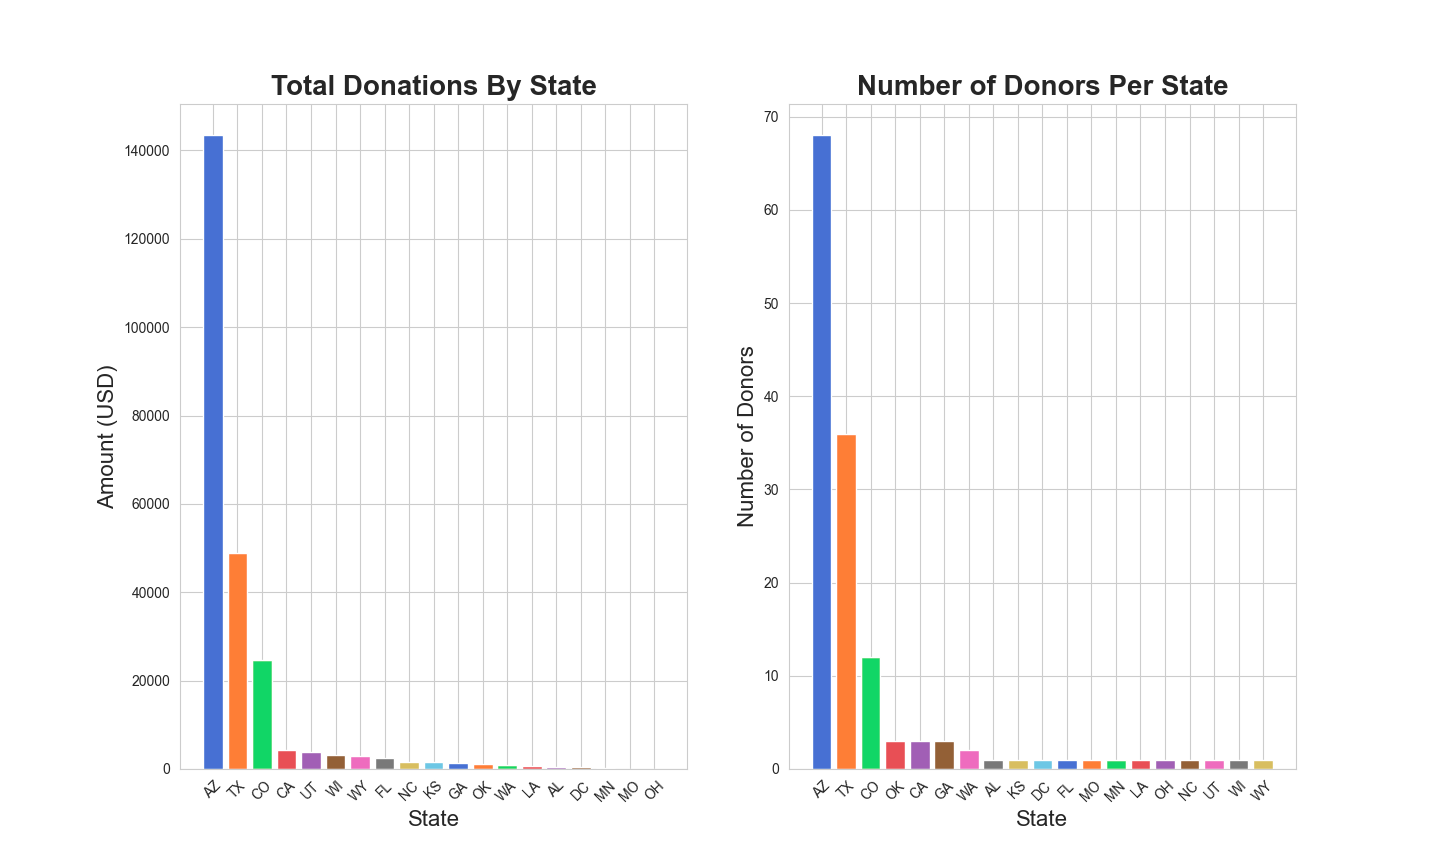

## Donor RFM Analysis & Segmentation 

### RFM Quantile-Based Scoring
>To segment donors based on Recency, Frequency, and Monetary values, we calculate RFM scores using quantile-based binning.
>
>We use the 25th, 50th, and 75th percentiles to define bin thresholds for each feature, with 0 and infinity serving as the lower and upper bounds, respectively.

In [ ]:
# Compute bins for RFM scoring using the quantiles of each feature distribution
rfm_features = ['recency', 'frequency', 'monetary']
rfm_bins = {}
def get_rfm_bins(dataframe, feature):
    quantiles = [0.25, 0.50, 0.75]
    bins = [dataframe[feature].quantile(quant) for quant in quantiles]
    bins.append(np.inf)
    bins.insert(0, 0)
    return bins

# Generate bins for each RFM feature
for feature in rfm_features:
    rfm_bins[f'{feature[0]}_bins'] = get_rfm_bins(donors_df, feature)

> Each donor is assigned an RFM score based on the quantile bin they fall into.

In [ ]:
# Compute recency scores
donors_df['r_score'] = pd.cut(donors_df['recency'], bins = rfm_bins['r_bins'], labels = [4, 3, 2, 1])

# Compute frequency scores
donors_df['f_score'] = pd.cut(donors_df['frequency'], bins = rfm_bins['f_bins'], labels = [1, 2, 3, 4])

# Compute monetary scores
donors_df['m_score'] = pd.cut(donors_df['monetary'], bins = rfm_bins['m_bins'], labels = [1, 2, 3, 4])

>The final RFM score is a three-digit string composed of the R, F, and M scores.

In [ ]:
# Compute full RFM score -- r_score + f_score + m_score
donors_df['rfm_score'] = donors_df['r_score'].astype('str') + donors_df['f_score'].astype('str') + donors_df['m_score'].astype('str')

# View donors_df, post-scoring
donors_df.head()

### Assigning Donor Segments Using RFM Scores
>We define donor segments using a regular expression map applied to the RFM score (Recency, Frequency, Monetary).
>
>The segments are as follows:
>- `champions`: Donors who gave the most recently, the most frequently, and the most generously overall.
>- `loyal_donors`: Donors who gave the most frequently and recently, excluding `champions`.
>- `potential_loyalists`: Donors who gave recently but not yet as frequently as `loyal_donors`.
>- `at_risk`: Donors who gave often and generously in the past, but not recently.
>- `lapsed_donors`: Donors who gave a moderate to high amount, somewhat freqently, but a long time ago.
>- `other`: Donors who do not fall into any of the previously mentioned segments.

In [ ]:
# Define a segmentation map using regular expressions and RFM scores
seg_map = {
    r'2[3-4][3-4]': 'at_risk', # gave often and generously in the past, but not recently
    r'1[2-3][2-4]': 'lapsed_donors', # gave a moderate to high amount, somewhat frequently, but a long time ago
    r'[3-4]4[2-3]': 'loyal_donors', # gave the most frequently and recently, excluding the 'champions'
    r'[3-4][2-3][2-3]': 'potential_loyalists', # gave recently, but not yet as frequently as 'loyal_donors' 
    r'[3-4]44': 'champions' # gave the most recently, the most frequently, and the most generously overall
}

# Segment donors according to seg_map, adding easily identifiable lables (e.g., 'lapsed_donors')
donors_df['segment'] = donors_df['rfm_score'].replace(seg_map, regex=True)

# Label all other donors--that don't fall into the defined segments--as 'other'
donors_df.loc[donors_df['segment'].str.contains(r'[1-4]', regex = True), 'segment'] = 'other'

# View the final donors_df DataFrame
donors_df.head()

> This segmentation strategy is adapted from the article:
> [Customer Segmentation with RFM Analysis using Python](https://medium.com/@gurkanc/customer-segmentation-with-rfm-analysis-using-python-8ba043252d33)

## Donor Segmentation Overview & Insights

### Donor Segment Behavior Analysis
> To better understand donor behavior after RFM scoring, we used bar plots to summarize:
> - The **number of donors** in each segment.
> - The corresponding **total donation value** of each segment.

In [ ]:
# Initialize figure with two subplots
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

# Set figure style
sns.set_style("whitegrid")

# Define a color palette to be used in the following plots -- unique colors for each donor segment
palette = sns.color_palette("muted", 6) 

# Alphabetically order the segments for consistency in visuals 
ordered_segments = sorted(donors_df['segment'].unique())

# Count plot for donor segments 
sns.countplot(data = donors_df, x = 'segment', palette = palette, ax = ax[0], order = ordered_segments)
ax[0].set_xlabel('Donor Segment', fontsize = 16)
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].set_title('Number of Donors Per Segment', fontsize = 20, fontweight = 'bold')

# Compute the total amount in donations per donor segment 
segment_monetary = donors_df.groupby('segment', as_index = False).agg({'monetary' : 'sum'})

# Bar plot for total donations per segment
sns.barplot(data = segment_monetary, x = 'segment', y = 'monetary', palette = palette, ax = ax[1], order = ordered_segments)
ax[1].set_xlabel('Donor Segment', fontsize = 16)
ax[1].set_ylabel('Amount (USD)', fontsize = 16)
ax[1].set_title('Total Donations Per Segment', fontsize = 20, fontweight = 'bold')
fig.tight_layout()
plt.savefig('donor_segmentation.png')

> **Number of Donors per Segment**:
>- This count plot shows how many donors fall into each segment.
>- Most donors belong to the `other` category, followed by `potential_loyalists`, indicating a large portion of the donor base is either uncategorized or emerging in loyalty.
>  
> **Total Donations per Segment**:
>- This bar plot highlights the total monetary contribution of each segment.
>- The majority of donations come from `champions`, followed by `other`, `at_risk`, and `potential_loyalists`, suggesting that while the `other` group is large, `champions` remain the most financially impactful.

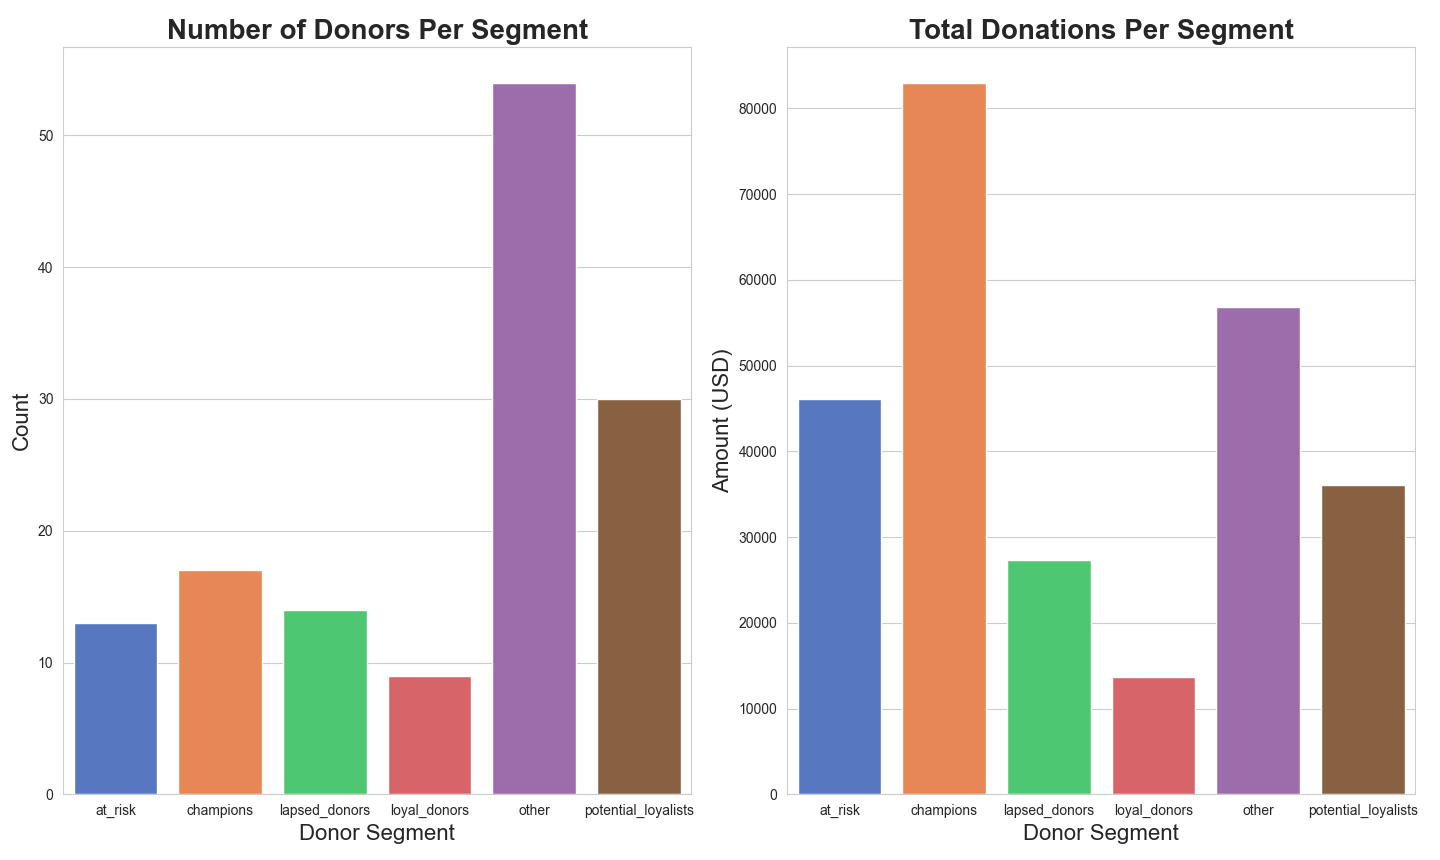

### Donor Segmentation by State: Arizona, Texas, and Colorado
>To explore how donor behavior varies geographically, we generated a heatmap showing the number of donors in each RFM segment across three key states (containing the highest volume of donors across all states): Arizona (AZ), Texas (TX), and Colorado (CO).
>
>Each cell shows the donor count for a specific segment and state combination.

In [ ]:
# Filter for states of interest
target_states_df = donors_df[donors_df['State'].isin(['AZ', 'TX', 'CO'])]

# Group by state & donor segment, and compute the number of donors
donor_counts = target_states_df.groupby(['State', 'segment']).agg({'Donor Name': 'count'})
donor_counts.rename(columns = {'Donor Name': 'count'}, inplace = True)

# Pivot donor_counts for heatmap format
segment_counts_pivot = donor_counts.unstack(fill_value = 0)

# Determine segment order for x-axis labeling 
segment_order = ['at_risk', 'champions', 'lapsed_donors', 'loyal_donors', 'other', 'potential_loyalists']

# Initialize figure 
fig = plt.figure(figsize=(15,8))

# Heat map for donor count by State & segment 
sns.heatmap(data = segment_counts_pivot, cmap = 'vlag', annot = True, linecolor = 'black', xticklabels = segment_order, linewidths = 0.5, cbar_kws = {'label': 'Donor Count'})
plt.title('Donor Segment Distribution Across States', fontsize = 20, fontweight = 'bold')
plt.xlabel('Donor Segment', fontsize = 16)
plt.ylabel('State', fontsize = 16)
plt.savefig('segment_heatmap.png')

> This visualization highlights which regions have the strongest presence of high-value segments like `champions` and `loyal_donors`, as well as which areas may require renewed engagement (`lapsed_donors`, `at_risk`).
> - Arizona has the largest number of donors in both the `champions` and `other` segments, suggesting a mix of highly engaged and uncategorized donors.
> - Colorado shows a relatively balanced distribution across segments, indicating a symmetric but less concentrated donor base.
> - Texas is dominated by the `potential_loyalists` and `other` segments, indicating an opportunity to cultivate long-term loyalty among a sizable group of donors.
>
> When conducting in-person donor engagement and fundraising in the U.S., we can prioritize celebrating `champions` in Arizona—our most generous and consistent supporters—and nurturing `potential_loyalists` in Texas to build long-term donor relationships.

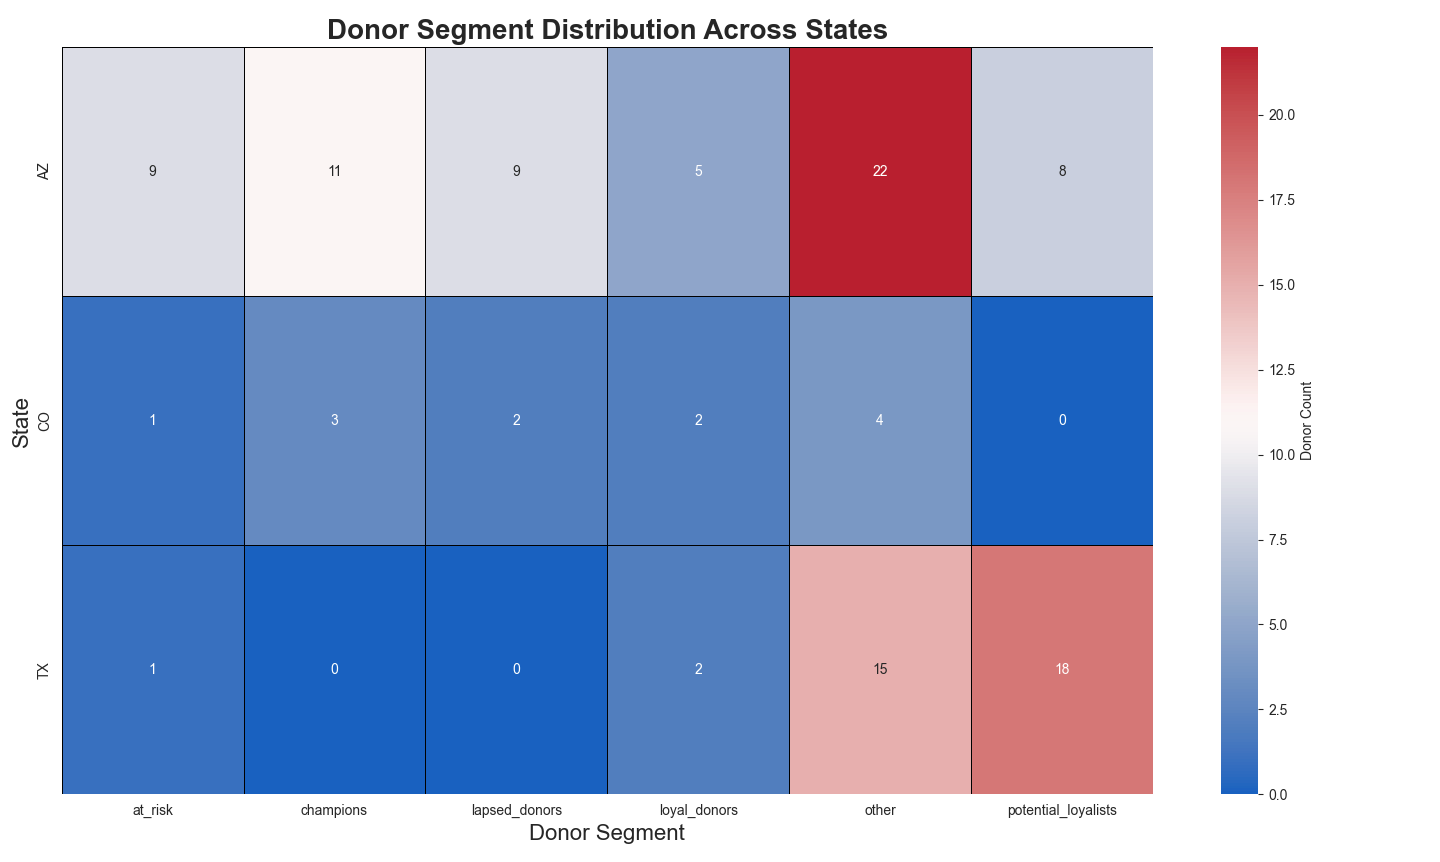

In [ ]:
# Export final donors_df DataFrame to csv file 
donors_df.to_csv('donors_final.csv', index = False)

## Key Insights & Recommendations
> **1. One-Time Donors Present a Strategic Opportunity**
>
> Approximately **22% of donors have given only once**, representing around **30 individuals**. These one-time donors are a **prime target for re-engagement efforts**. With thoughtful outreach and communication, they may be converted into repeat or even recurring donors.
>
>**3. Donor Giving Patterns Show Consistency**
>   
>The distribution of donation amounts among most donors is **fairly symmetric**, suggesting two possible patterns: (1) consistent giving behavior over time or (2) absence of extreme outliers in donation size. While this consistency indicates stability in contributions, it also highlights the **lack of large one-time gifts**—a common driver of year-end fundraising success.
>
>**3. Recency Data Indicates Strong Recent Engagement**
>
>The `recency` box plot reveals a **highly right-skewed distribution**, where the median, lower quartile, and minimum values are closely aligned. This suggests that **most donors have contributed recently**, with relatively few long-lapsed donors. This pattern indicates healthy, ongoing engagement across the donor base.
>
>**4. Geographic Trends Highlight Key Donor Hubs**
>   
>Donors from **Arizona** and **Texas** not only make up the **largest share of the U.S. donor base** but also generate the **highest donation volumes**. These states hold significant strategic value for future campaigns and **localized engagement** efforts. When conducting in-person fundraising or donor relations during visits to the U.S., prioritizing Arizona and Texas may yield the greatest return.
>
>**5. Re-evaluating the "Other" Segment**
>   
>At first glance, the `other` donor segment appeared **surprisingly large**. However, this is due to the **exclusion of one-time donors** (`frequency` = 1) **from the main segment classifications** (e.g. `champions`, `at_risk`, etc.). As a result, the 30 one-time donors were grouped into `other`, inflating this category. Future segmentation efforts should consider **isolating one-time donors as their own distinct group** for more accurate analysis.
>
>**6. Champions Drive the Majority of Donations**
>   
>Unsurprisingly, `champions` (high-value, high-frequency, and recent donors) account for the **majority of donation volume**. This underscores the importance of **recognizing and retaining** these key contributors. We recommend implementing targeted **appreciation campaigns**, such as **personalized thank-you messages**, to reinforce their engagement and encourage continued giving.
>
>**7. Champion and Potential Loyalist Distribution by State**
>   
>While **Arizona** leads in the number of `champions`, **Texas** is home to the largest population of `potential_loyalists`—donors who exhibit frequent and relatively recent giving behavior but have not yet reached the consistency or volume of `loyalists`.



## Limitations and Future Directions
>
>**1. Limited Donor Attributes**
>
>This analysis did not incorporate donor demographics or campaign-specific information, both of which are critical for understanding giving behavior at a deeper level. Incorporating data such as age, location, communication engagement (e.g., email opens, social media interactions), and response to specific fundraising campaigns would allow for more targeted segmentation and actionable insights. We recommend collecting this data in future analyses—manually, if necessary—to enable a more holistic understanding of our donor base.
>
>**2. Incomplete Donor Coverage**
>
>The dataset used represents only a subset of the broader Tokyo Student Mobilization donor base. As such, the findings—especially geographic and behavioral trends—may not generalize to the full population. Expanding the scope to include more comprehensive donor data will enhance representativeness and allow for more confident conclusions.
>
>**3. Fragmented Donation Histories**
>
>Due to organizational structure, which includes multiple subdivisions (individual, state, and national levels), this analysis reflects donations to only one specific subdivision. Donors who contribute to multiple projects or individuals across the organization may have fragmented records that are not captured here. Because centralized access to cumulative donor data is limited, achieving a full view of each donor’s giving history remains a challenge.
>
>**4. Binning Limitations in RFM Scoring**
>
>RFM segmentation in this analysis relied on quantile-based binning to assign scores across recency, frequency, and monetary value. However, given that all three features—especially recency—exhibited right-skewed distributions, this method may lead to misclassification. For instance, donors with very similar scores might fall into different segments solely due to quantile boundaries. Future work should explore more robust segmentation approaches, such as k-means clustering or other unsupervised machine learning techniques, to improve classification accuracy.



## Conclusion
>This analysis aimed to segment donors based on their giving behavior in order to guide strategic engagement, retention initiatives, and geographically informed fundraising efforts. Key findings revealed that a small subset of high-value donors—classified as champions—accounted for the majority of total donations. In contrast, approximately 22% of donors have given only once, highlighting a significant opportunity for re-engagement and cultivation.
>
>Geographic analysis showed a clear concentration of donors in Arizona and Texas, both in terms of volume and contribution amount. These findings suggest that future in-person fundraising efforts, particularly during annual visits to the U.S., should prioritize these regions for maximum impact.
>
>To strengthen donor retention, targeted outreach should be focused on donors identified as at-risk or lapsed, using personalized communication efforts to re-establish engagement. Looking ahead, future analyses should integrate donor demographics, campaign-specific data, and engagement metrics to enable more comprehensive segmentation. Additionally, implementing more advanced clustering techniques—such as k-means or other unsupervised machine learning models—could yield more refined donor groupings and actionable insights.